In [1]:
import os, sys, time
import pickle
from tqdm.notebook import tqdm
import pandas as pd
import json
import numpy as np
from collections import defaultdict
from scipy import stats
from datasets import load_from_disk
from transformers import ViTForImageClassification
from utils.helper import get_device
from utils.vit_util import transforms, transforms_c100
from utils.constant import ViTExperiment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import torch
device = get_device()

def src_tgt_selection(mis_ranking, mis_indices, tgt_rank):
    """
    src-tgt型のrepairをしたい場合に使う
    src-tgt型の誤分類において，tgt_rank番目の誤分類情報を取り出す．
    具体的には予測ラベル，正解ラベル，該当サンプルのインデックスを取り出す．
    """
    # ランキングから対象の誤分類情報を取り出す
    slabel, tlabel, mis_cnt = mis_ranking[tgt_rank-1]
    tgt_mis_indices = mis_indices[slabel][tlabel]
    return slabel, tlabel, tgt_mis_indices

def tgt_selection(met_dict, mis_indices, tgt_rank, used_met="f1"):
    """
    tgt型のrepairをしたい場合に使う
    tgt型の誤分類において，tgt_rank番目にused_metの悪いラベルを特定し，その情報を取り出す．
    具体的には対象ラベル，該当サンプルのインデックスを取り出す．
    """
    metrics = met_dict[used_met]
    num_labels = len(metrics)
    met_ranking = sorted(enumerate(metrics), key=lambda x: x[1])
    tgt_label = met_ranking[tgt_rank-1][0]
    tgt_mis_indices = []
    for pred_label in range(num_labels):
        for true_label in range(num_labels):
            if (pred_label == tgt_label or true_label == tgt_label) and pred_label != true_label:
                tgt_mis_indices.extend(mis_indices[pred_label][true_label])
    return tgt_label, tgt_mis_indices

2024-09-25 16:46:01.603016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 16:46:02.927725: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-09-25 16:46:02.927895: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-09-25 16:46:02.927910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Device: cuda


In [3]:
ds_name = "c100"
k = 0
tgt_rank = 1
misclf_type = "tgt"
# pretrained modelのロード
pretrained_dir = getattr(ViTExperiment, ds_name).OUTPUT_DIR.format(k=k)
model = ViTForImageClassification.from_pretrained(pretrained_dir).to(device)
model.eval()
# 対象の設定
start_li = 0
target_li = -1
end_li = model.vit.config.num_hidden_layers

# datasetごとに違う変数のセット
if ds_name == "c10":
    tf_func = transforms
    label_col = "label"
    num_labels = 10
elif ds_name == "c100":
    tf_func = transforms_c100
    label_col = "fine_label"
    num_labels = 100
else:
    NotImplementedError

vscore_before_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", "vscores_before")
vscore_after_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", "vscores_after")
vscore_med_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", "vscores")
tgt_split = "repair"

misclf_info_dir = os.path.join(pretrained_dir, "misclf_info")
# インデックスのロード
with open(os.path.join(misclf_info_dir, f"{tgt_split}_mis_indices.pkl"), "rb") as f:
    mis_indices = pickle.load(f)
# ランキングのロード
with open(os.path.join(misclf_info_dir, f"{tgt_split}_mis_ranking.pkl"), "rb") as f:
    mis_ranking = pickle.load(f)
# メトリクスのロード
with open(os.path.join(misclf_info_dir, f"{tgt_split}_met_dict.pkl"), "rb") as f:
    met_dict = pickle.load(f)
# 修復対象の選択
if misclf_type == "src_tgt":
    slabel, tlabel, tgt_mis_indices = src_tgt_selection(mis_ranking, mis_indices, tgt_rank)
    tgt_mis_indices = mis_indices[slabel][tlabel]
    print(f"tgt_misclf: {slabel} -> {tlabel}, len(tgt_mis_indices): {len(tgt_mis_indices)}")
elif misclf_type == "tgt":
    tlabel, tgt_mis_indices = tgt_selection(met_dict, mis_indices, tgt_rank, used_met="f1")
    print(f"tgt_misclf: {tlabel}, len(tgt_mis_indices): {len(tgt_mis_indices)}")

tgt_misclf: 47, len(tgt_mis_indices): 54


# ViTレイヤの最終層から2層目

ba: before, tgt_split: repair
vscores shape (cor): (768, 12)
vscores shape (mis): (768, 12)
sum(condition)=77


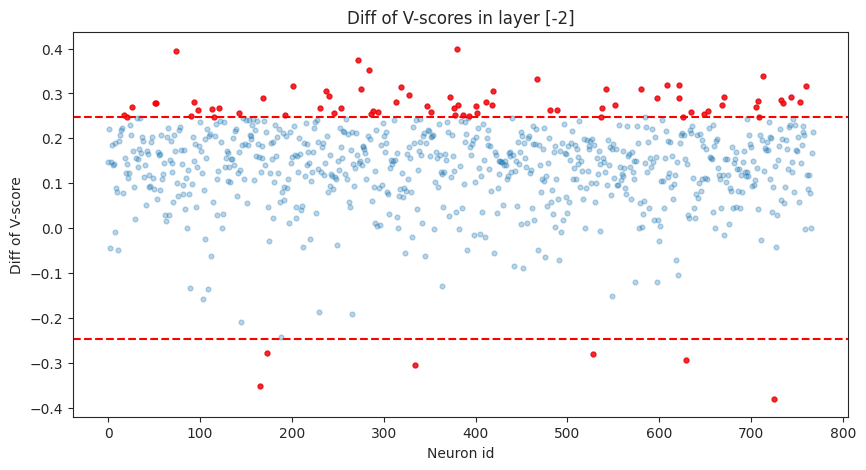

cosine_similarity=[0.96932554 0.94283785 0.94105305 0.95549866 0.95637091 0.95709956
 0.95481435 0.95415518 0.95418268 0.95376171 0.89705161 0.85956322]


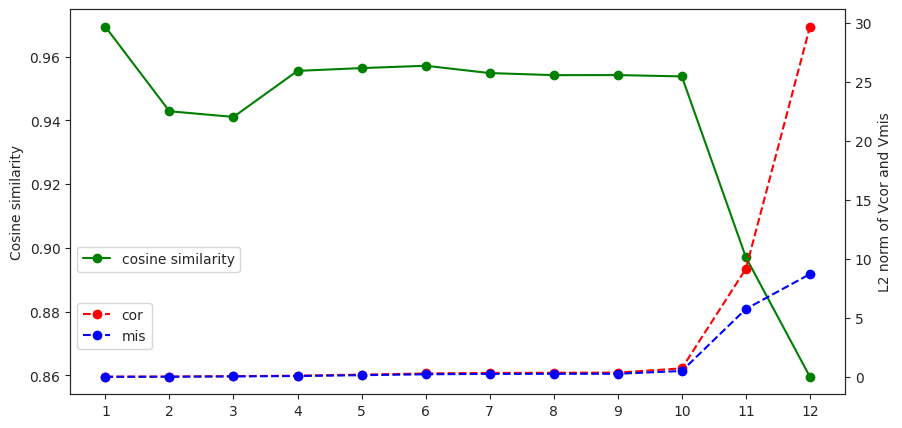

ba: intermediate, tgt_split: repair
vscores shape (cor): (3072, 12)
vscores shape (mis): (3072, 12)
sum(condition)=308


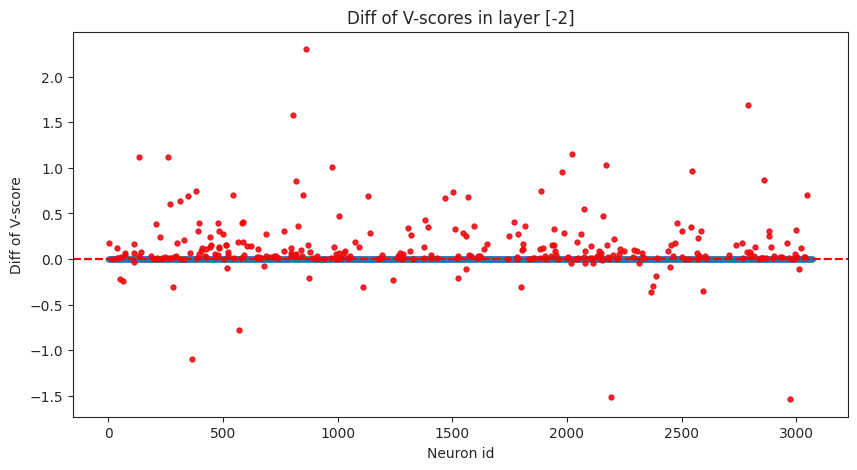

cosine_similarity=[0.86609733 0.86284741 0.98276053 0.90408481 0.91612801 0.92740897
 0.86332022 0.87929668 0.88610954 0.88057499 0.56973452 0.32854489]


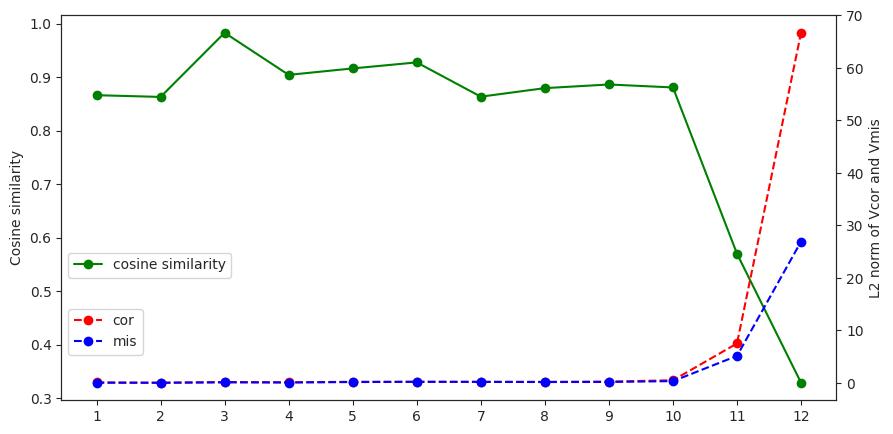

ba: after, tgt_split: repair
vscores shape (cor): (768, 12)
vscores shape (mis): (768, 12)
sum(condition)=77


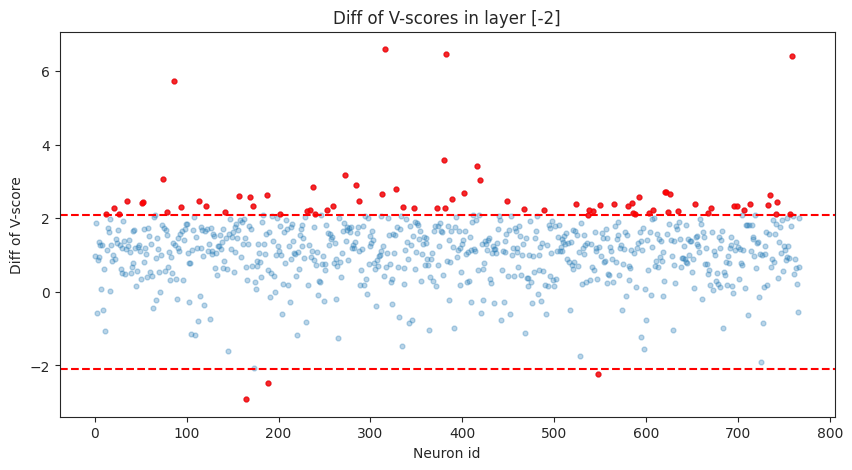

cosine_similarity=[0.96993013 0.93687862 0.93167299 0.94830798 0.95494317 0.95629478
 0.9536195  0.95288928 0.9455315  0.96089867 0.90287813 0.84126361]


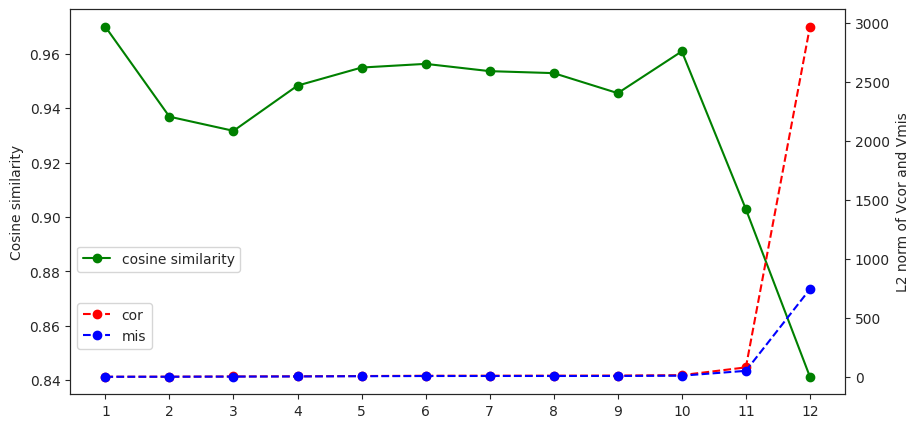

In [4]:
layers4show = [-2]
vdiff_dic = defaultdict(np.array)

for ba, vscore_dir in zip(["before", "intermediate", "after"], [vscore_before_dir, vscore_med_dir, vscore_after_dir]):
    vmap_dic = defaultdict(defaultdict)
    print(f"ba: {ba}, tgt_split: {tgt_split}")
    vmap_dic[tgt_split] = defaultdict(defaultdict)
    # 正解と不正解時のvscoreを読み込む
    for cor_mis in ["cor", "mis"]:
        vmap_dic[tgt_split][cor_mis] = defaultdict(np.array)
        ds_type = f"ori_{tgt_split}"
        if cor_mis == "cor":
            vscore_save_path = os.path.join(vscore_dir, f"vscore_l1tol{end_li}_all_label_{ds_type}_{cor_mis}.npy")
        else:
            if misclf_type == "src_tgt":
                vscore_save_path = os.path.join(vscore_dir, f"vscore_l1tol{end_li}_{slabel}to{tlabel}_{ds_type}_{cor_mis}.npy")
            elif misclf_type == "tgt":
                vscore_save_path = os.path.join(vscore_dir, f"vscore_l1tol{end_li}_{tlabel}_{ds_type}_{cor_mis}.npy")
        vscores = np.load(vscore_save_path)
        vmap_dic[tgt_split][cor_mis] = vscores.T
        print(f"vscores shape ({cor_mis}): {vmap_dic[tgt_split][cor_mis].shape}")
    # vscoresのcorとmisの差分をヒートマップで可視化
    vmap_cor = vmap_dic[tgt_split]["cor"]
    vmap_mis = vmap_dic[tgt_split]["mis"]
    vmap_diff = vmap_cor - vmap_mis
    vdiff_dic[ba] = vmap_diff
    # 横軸をニューロン，縦軸をスコアとした折れ線グラフ
    plt.figure(figsize=(10, 5))
    # vmap[:, layers4show] の絶対値の上位10%だけマーカーの色を赤に変える
    top10 = np.percentile(np.abs(vmap_diff[:, layers4show]), 90)
    condition = np.abs(vmap_diff[:, layers4show]).reshape(-1) > top10
    print(f"sum(condition)={sum(condition)}")
    # top10の値に横線を引く
    plt.axhline(y=top10, color="red", linestyle="--")
    plt.axhline(y=-top10, color="red", linestyle="--")
    plt.scatter(np.array(range(len(vmap_diff[:, layers4show]))), vmap_diff[:, layers4show], alpha=0.3, s=12)
    plt.scatter(np.array(range(len(vmap_diff[:, layers4show])))[condition], vmap_diff[:, layers4show][condition], alpha=0.8, s=12, color="red")
    plt.xlabel("Neuron id")
    plt.ylabel("Diff of V-score")
    plt.title(f"Diff of V-scores in layer {layers4show}")
    plt.show()
    # vmap_dic[used_column][tgt_ct]["cor"] と vmap_dic[used_column][tgt_ct]["mis"] の，行ごとの内積を取る
    dot_products = np.sum(vmap_cor * vmap_mis, axis=0)
    a_norms = np.linalg.norm(vmap_cor, axis=0)
    b_norms = np.linalg.norm(vmap_mis, axis=0)
    cosine_similarity = dot_products / (a_norms * b_norms)
    print(f"cosine_similarity={cosine_similarity}") # corとmisのcos類似度
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(cosine_similarity, color="g", marker="o", label="cosine similarity")
    ax1.set_ylabel('Cosine similarity')
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    ax2.plot(a_norms, color="r", marker="o", linestyle="--", label="cor")
    ax2.plot(b_norms, color="b", marker="o", linestyle="--", label="mis")
    ax2.set_xlabel("Layer")
    ax2.set_ylabel("L2 norm of Vcor and Vmis")
    # グラフに凡例を追加
    ax1.legend(loc='lower left', bbox_to_anchor=(0, 0.3))
    ax2.legend(loc='lower left', bbox_to_anchor=(0, 0.1))
    plt.xticks(np.arange(0, end_li-start_li, 1), np.arange(start_li+1, end_li+1, 1))
    plt.show()

# ViTレイヤの最終層

ba: before, tgt_split: repair
vscores shape (cor): (768, 12)
vscores shape (mis): (768, 12)
sum(condition)=77


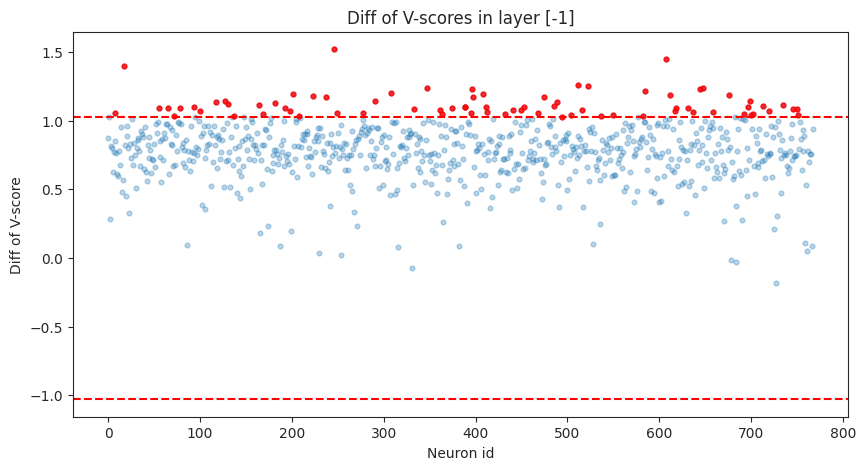

cosine_similarity=[0.96932554 0.94283785 0.94105305 0.95549866 0.95637091 0.95709956
 0.95481435 0.95415518 0.95418268 0.95376171 0.89705161 0.85956322]


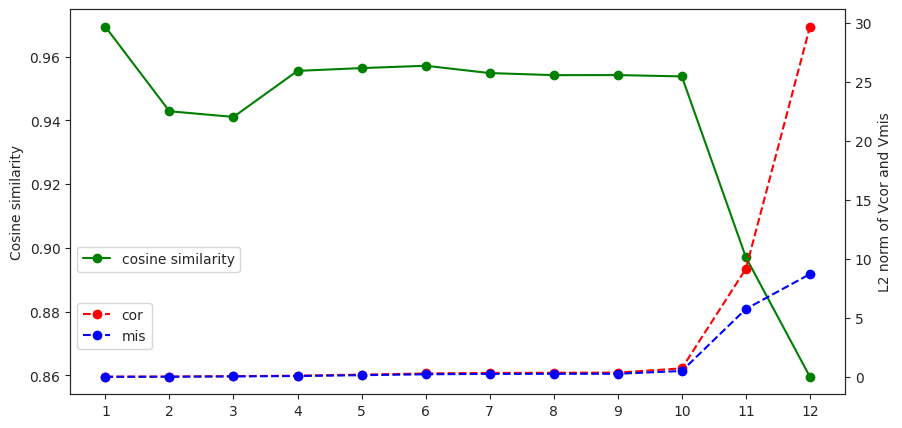

ba: intermediate, tgt_split: repair
vscores shape (cor): (3072, 12)
vscores shape (mis): (3072, 12)
sum(condition)=308


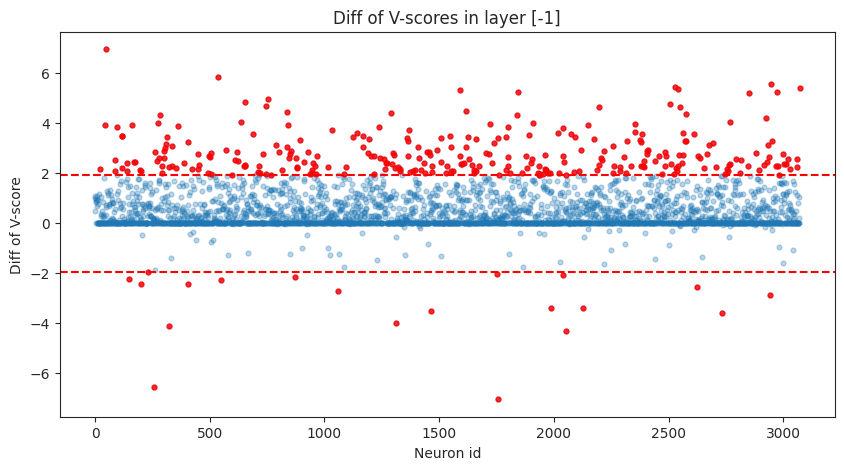

cosine_similarity=[0.86609733 0.86284741 0.98276053 0.90408481 0.91612801 0.92740897
 0.86332022 0.87929668 0.88610954 0.88057499 0.56973452 0.32854489]


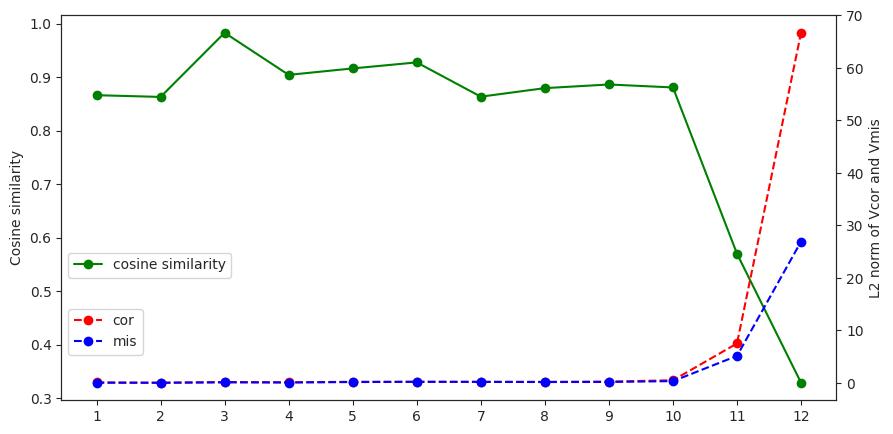

ba: after, tgt_split: repair
vscores shape (cor): (768, 12)
vscores shape (mis): (768, 12)
sum(condition)=77


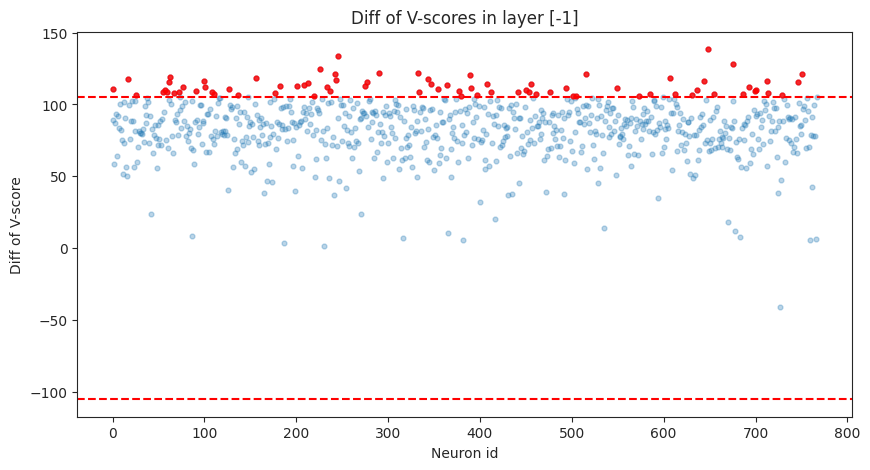

cosine_similarity=[0.96993013 0.93687862 0.93167299 0.94830798 0.95494317 0.95629478
 0.9536195  0.95288928 0.9455315  0.96089867 0.90287813 0.84126361]


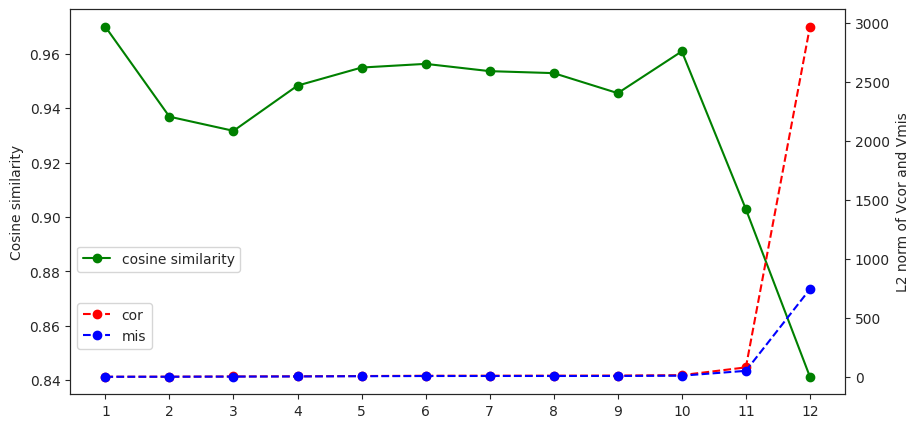

In [5]:
layers4show = [-1]
vdiff_dic = defaultdict(np.array)

for ba, vscore_dir in zip(["before", "intermediate", "after"], [vscore_before_dir, vscore_med_dir, vscore_after_dir]):
    vmap_dic = defaultdict(defaultdict)
    print(f"ba: {ba}, tgt_split: {tgt_split}")
    vmap_dic[tgt_split] = defaultdict(defaultdict)
    # 正解と不正解時のvscoreを読み込む
    for cor_mis in ["cor", "mis"]:
        vmap_dic[tgt_split][cor_mis] = defaultdict(np.array)
        ds_type = f"ori_{tgt_split}"
        if cor_mis == "cor":
            vscore_save_path = os.path.join(vscore_dir, f"vscore_l1tol{end_li}_all_label_{ds_type}_{cor_mis}.npy")
        else:
            if misclf_type == "src_tgt":
                vscore_save_path = os.path.join(vscore_dir, f"vscore_l1tol{end_li}_{slabel}to{tlabel}_{ds_type}_{cor_mis}.npy")
            elif misclf_type == "tgt":
                vscore_save_path = os.path.join(vscore_dir, f"vscore_l1tol{end_li}_{tlabel}_{ds_type}_{cor_mis}.npy")
        vscores = np.load(vscore_save_path)
        vmap_dic[tgt_split][cor_mis] = vscores.T
        print(f"vscores shape ({cor_mis}): {vmap_dic[tgt_split][cor_mis].shape}")
    # vscoresのcorとmisの差分をヒートマップで可視化
    vmap_cor = vmap_dic[tgt_split]["cor"]
    vmap_mis = vmap_dic[tgt_split]["mis"]
    vmap_diff = vmap_cor - vmap_mis
    vdiff_dic[ba] = vmap_diff
    # 横軸をニューロン，縦軸をスコアとした折れ線グラフ
    plt.figure(figsize=(10, 5))
    # vmap[:, layers4show] の絶対値の上位10%だけマーカーの色を赤に変える
    top10 = np.percentile(np.abs(vmap_diff[:, layers4show]), 90)
    condition = np.abs(vmap_diff[:, layers4show]).reshape(-1) > top10
    print(f"sum(condition)={sum(condition)}")
    # top10の値に横線を引く
    plt.axhline(y=top10, color="red", linestyle="--")
    plt.axhline(y=-top10, color="red", linestyle="--")
    plt.scatter(np.array(range(len(vmap_diff[:, layers4show]))), vmap_diff[:, layers4show], alpha=0.3, s=12)
    plt.scatter(np.array(range(len(vmap_diff[:, layers4show])))[condition], vmap_diff[:, layers4show][condition], alpha=0.8, s=12, color="red")
    plt.xlabel("Neuron id")
    plt.ylabel("Diff of V-score")
    plt.title(f"Diff of V-scores in layer {layers4show}")
    plt.show()
    # vmap_dic[used_column][tgt_ct]["cor"] と vmap_dic[used_column][tgt_ct]["mis"] の，行ごとの内積を取る
    dot_products = np.sum(vmap_cor * vmap_mis, axis=0)
    a_norms = np.linalg.norm(vmap_cor, axis=0)
    b_norms = np.linalg.norm(vmap_mis, axis=0)
    cosine_similarity = dot_products / (a_norms * b_norms)
    print(f"cosine_similarity={cosine_similarity}") # corとmisのcos類似度
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(cosine_similarity, color="g", marker="o", label="cosine similarity")
    ax1.set_ylabel('Cosine similarity')
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    ax2.plot(a_norms, color="r", marker="o", linestyle="--", label="cor")
    ax2.plot(b_norms, color="b", marker="o", linestyle="--", label="mis")
    ax2.set_xlabel("Layer")
    ax2.set_ylabel("L2 norm of Vcor and Vmis")
    # グラフに凡例を追加
    ax1.legend(loc='lower left', bbox_to_anchor=(0, 0.3))
    ax2.legend(loc='lower left', bbox_to_anchor=(0, 0.1))
    plt.xticks(np.arange(0, end_li-start_li, 1), np.arange(start_li+1, end_li+1, 1))
    plt.show()

# FLのトライアル

In [6]:
# just for check
for k, v in vdiff_dic.items():
    print(f"{k}: {v.shape}") # これは全レイヤー分入ってる

before: (768, 12)
intermediate: (3072, 12)
after: (768, 12)


In [7]:
# 特定のレイヤだけ取り出す
tgt_layer = 11
tgt_vdiff_dic = defaultdict(np.array)
for k, v in vdiff_dic.items():
    tgt_vdiff_dic[k] = np.abs(v[:, tgt_layer])
    print(f"{k}: {tgt_vdiff_dic[k].shape}")
    print(f"[min, max] = [{np.min(tgt_vdiff_dic[k])}, {np.max(tgt_vdiff_dic[k])}]")

before: (768,)
[min, max] = [0.012494645040943997, 1.5209469720522772]
intermediate: (3072,)
[min, max] = [1.8526724655422497e-07, 7.035775280009313]
after: (768,)
[min, max] = [1.332097530624921, 138.44346124306938]


In [8]:
# 降順のランクをペアにしたdictにする
tgt_vdiff_dic_with_rank = defaultdict(defaultdict)

def rank_descending(x):
    # x を降順に並べ替えるためのインデックスを取得
    sorted_indices = np.argsort(x)[::-1]
    # 順位用の空の配列を準備
    ranks = np.empty_like(sorted_indices)
    # インデックスを使って順位を設定
    ranks[sorted_indices] = np.arange(len(x))
    return ranks

for k, v in tgt_vdiff_dic.items():
    tgt_vdiff_dic_with_rank[k]["vdiff"] = v
    tgt_vdiff_dic_with_rank[k]["rank"] = rank_descending(v)
    print(f"(vdiff) {k}: {tgt_vdiff_dic_with_rank[k]['vdiff'].shape}")
    print(f"(rank) {k}: {tgt_vdiff_dic_with_rank[k]['rank'].shape}")

(vdiff) before: (768,)
(rank) before: (768,)
(vdiff) intermediate: (3072,)
(rank) intermediate: (3072,)
(vdiff) after: (768,)
(rank) after: (768,)


In [9]:
def return_rank(x, i, order="desc"):
    # x[i] の順位を返す
    if order == "desc":
        return np.argsort(x)[::-1].tolist().index(i)
    elif order == "asc":
        return np.argsort(x).tolist().index(i)
    else:
        raise NotImplementedError

In [10]:
# tgt_vdiff_dic_with_rank[k]["rank"]のi番目が，tgt_vdiff_dic_with_rank[k]["vdiff"]のi番めの順位になっていることを確認
for i, r in enumerate(tgt_vdiff_dic_with_rank["after"]["rank"]):
    assert return_rank(tgt_vdiff_dic_with_rank["after"]["vdiff"], i) == r, f"Error: {i}, {r}"

In [11]:
# tgt_vdiff_dic_with_rankのbefore, intermediate, afterでそれぞれランクがtop x のインデックスを取得
top_idx_dic = defaultdict(list)
for k, v in tgt_vdiff_dic_with_rank.items():
    if k == "intermediate":
        topx = 20
    else:
        topx = 5
    top_idx_dic[k] = np.where(v["rank"] < topx)[0]
    print(f"{k}: {top_idx_dic[k]}")

before: [ 17 246 512 522 607]
intermediate: [  49  255  536  654  744  756  837 1591 1618 1755 1842 2196 2506 2526
 2542 2549 2849 2946 2973 3071]
after: [226 246 333 648 675]


In [12]:
# top_idx_dic[k]のデカルト積を取る
from itertools import product
pos_before = list(product(top_idx_dic["before"], top_idx_dic["intermediate"]))
pos_after = list(product(top_idx_dic["intermediate"], top_idx_dic["after"]))
print(len(pos_before), len(pos_after))

100 100


In [13]:
tot_params = 1
for k, v in top_idx_dic.items():
    print(f"k={k}, len(v)={len(v)}")
    tot_params *= len(v)
tot_params

k=before, len(v)=5
k=intermediate, len(v)=20
k=after, len(v)=5


500

In [14]:
tgt_vdiff_dic_with_rank["after"]["vdiff"][top_idx_dic["after"]]

array([124.92661033, 133.71168369, 122.20358978, 138.44346124,
       127.99327918])

In [15]:
np.sort(tgt_vdiff_dic_with_rank["after"]["vdiff"])[::-1][:5]

array([138.44346124, 133.71168369, 127.99327918, 124.92661033,
       122.20358978])

順位の情報ではなくvdiff自体の値を直接使ってパレートフロントを取ればいい気もしてきた